<a href="https://colab.research.google.com/github/devCat404/UTAS/blob/main/specGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil
import uuid
from tqdm import tqdm

import IPython.display as ipd
from IPython.display import Audio

import librosa
import librosa.feature
import librosa.display
from librosa.display import specshow
from librosa.display import waveshow

import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/AICOSS/Tasmanian_Birdsong/"
PATH = os.path.join(BASE_PATH, "preprocessed.csv")
AUDIO = os.path.join(BASE_PATH, "Input_audio")

df = pd.read_csv(PATH)
df.head()

,sample,species,call_type,start,end,aug_method
0,BD060A_CH01_20240328_220014_16kHz_290_320.wav,Masked Owl,screech,9.00,12.36,original
1,BD060A_CH01_20240331_210000_16kHz_660_690.wav,Masked Owl,screech,19.96,23.96,original
2,BD060A_CH01_20240331_210000_16kHz_1020_1050.wav,Masked Owl,screech,16.06,18.13,original
3,CH07_20240703_180000_16kHz_1380_1410.wav,Masked Owl,screech,23.12,25.19,original
4,CH07_20240703_180000_16kHz_1810_1840.wav,Masked Owl,screech,18.65,20.72,original


In [ ]:
def extract_and_convert_mel(audio_dir, sr=22050, n_mels=128, target_shape=(64, 128)):
    data = []
    filenames = []

    for file in tqdm(os.listdir(audio_dir), desc="Mel-Spectrogram extracting"):
        try:
            file_path = os.path.join(audio_dir, file)
            y, _ = librosa.load(file_path, sr=sr)

            mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
            mel_db = librosa.power_to_db(mel, ref=np.max)

            mel_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)

            padded = np.zeros(target_shape)
            h, w = mel_norm.shape
            h_new = min(h, target_shape[0])
            w_new = min(w, target_shape[1])
            padded[:h_new, :w_new] = mel_norm[:h_new, :w_new]

            mel_img = np.expand_dims(padded, axis=0)

            data.append(mel_img.astype(np.float32))
            filenames.append(file)

        except Exception as e:
            print(f"[!] {file} 처리 중 오류: {e}")

    return np.array(data), filenames

In [ ]:
X, filenames = extract_and_convert_mel(audio_dir=AUDIO, target_shape=(64, 128))

X = (X - 0.5) * 2.0
print("전체 샘플 수:", len(X))
print("입력 텐서 shape:", X.shape)

Mel-Spectrogram extracting: 100%|██████████| 2000/2000 [01:16<00:00, 26.07it/s]


전체 샘플 수: 2000
입력 텐서 shape: (2000, 1, 64, 128)


In [ ]:
def show_mel_images(X, filenames=None, n=8):
    plt.figure(figsize=(n * 2, 3))
    for i in range(n):
        img = X[i].transpose(1, 2, 0)
        plt.subplot(1, n, i + 1)
        plt.imshow(img, aspect="auto", origin="lower", cmap="magma")
        plt.axis('off')
        if filenames:
            plt.title(filenames[i][:10], fontsize=8)
    plt.suptitle("Mel-Spectrogram Tensor", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

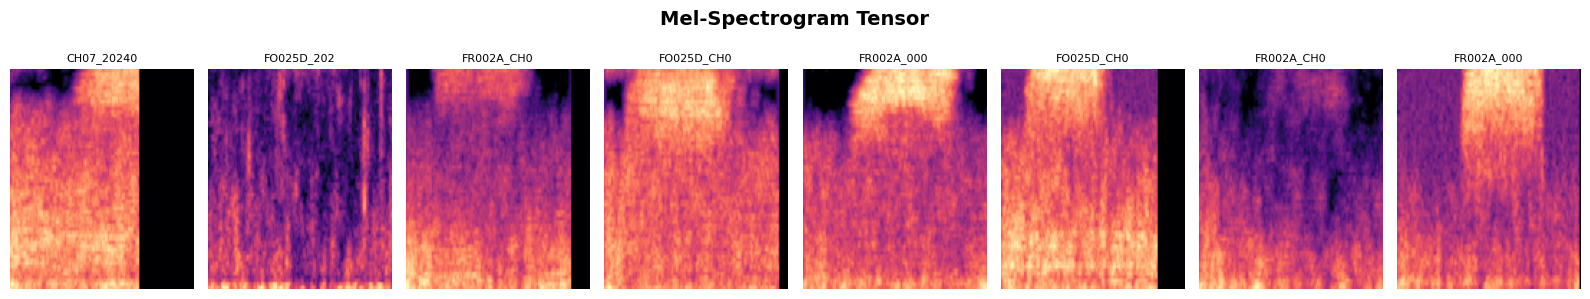

In [ ]:
show_mel_images(X, filenames=filenames, n=8)

In [ ]:
def prepare_dataset(X, filenames, base_csv_path, mel_csv_path, batch_size=32):
    if not os.path.exists(mel_csv_path):
        print("preprocessed_mel.csv 없음 → 생성 중...")
        df_base = pd.read_csv(base_csv_path)
        df_base = df_base[df_base['sample'].isin(filenames)]
        df_base.to_csv(mel_csv_path, index=False)
        print("preprocessed_mel.csv 저장 완료")
    else:
        print("preprocessed_mel.csv 로딩 완료")

    df = pd.read_csv(mel_csv_path)
    df = df.set_index('sample').loc[filenames].reset_index()

    labels = df['call_type'].values
    le = LabelEncoder()
    y = le.fit_transform(labels)

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=len(X_test_tensor), shuffle=False)

    return train_loader, val_loader, test_loader, le, (X_train_tensor, X_val_tensor, X_test_tensor), (y_train_tensor, y_val_tensor, y_test_tensor)

In [ ]:
CSV_BASE = os.path.join(BASE_PATH, "preprocessed.csv")
CSV_MEL = os.path.join(BASE_PATH, "preprocessed_mel.csv")

train_loader, val_loader, test_loader, le, X_split, y_split = prepare_dataset(
    X, filenames,
    base_csv_path=CSV_BASE,
    mel_csv_path=CSV_MEL
)

print("클래스 수:", len(le.classes_))
print("Train/Val/Test 샘플 수:", len(X_split[0]), len(X_split[1]), len(X_split[2]))

preprocessed_mel.csv 로딩 완료
클래스 수: 2
Train/Val/Test 샘플 수: 1440 360 200


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, n_classes=10, out_channels=1):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, 100)
        self.init_size = (16, 32)
        self.l1 = nn.Sequential(nn.Linear(z_dim + 100, 512 * self.init_size[0] * self.init_size[1]))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, out_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((noise, self.label_emb(labels)), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 512, *self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, n_classes=10, in_channels=1):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, 64 * 128)

        self.model = nn.Sequential(
            nn.Conv2d(in_channels + 1, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, stride=2, padding=1),
        )

    def forward(self, img, labels):
        label = self.label_emb(labels).view(labels.size(0), 1, 64, 128)
        d_in = torch.cat((img, label), 1)
        validity = self.model(d_in)
        return validity.view(img.size(0), -1).mean(1, keepdim=True)

In [ ]:
z_dim = 100
n_classes = len(le.classes_)
image_shape = (3, 64, 128)
lr = 0.0002
batch_size = 32
n_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
if device.type == "cuda":
    print("CUDA device name:", torch.cuda.get_device_name(0))
    print("CUDA device count:", torch.cuda.device_count())
else:
    print("CUDA not available, using CPU")

CUDA not available, using CPU


In [ ]:
G = Generator(z_dim=z_dim, n_classes=n_classes).to(device)
D = Discriminator(n_classes=n_classes).to(device)

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
adversarial_loss = nn.BCEWithLogitsLoss()

In [ ]:
MODEL_DIR = os.path.join(BASE_PATH, "Models")
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
def save_model_and_history(generator, discriminator, g_optimizer, d_optimizer, history, filename="specgan_final.pkl"):
    checkpoint = {
        "generator": generator.state_dict(),
        "discriminator": discriminator.state_dict(),
        "g_optimizer": g_optimizer.state_dict(),
        "d_optimizer": d_optimizer.state_dict(),
        "history": history,
        "epoch": epoch
    }
    filepath = os.path.join(MODEL_DIR, filename)
    with open(filepath, "wb") as f:
        pickle.dump(checkpoint, f)


def load_model_and_history(generator, discriminator, g_optimizer, d_optimizer, filename):
    filepath = os.path.join(MODEL_DIR, filename)

    with open(filepath, "rb") as f:
      checkpoint = pickle.load(f)

    generator.load_state_dict(checkpoint["generator"])
    discriminator.load_state_dict(checkpoint["discriminator"])
    g_optimizer.load_state_dict(checkpoint["g_optimizer"])
    d_optimizer.load_state_dict(checkpoint["d_optimizer"])
    history = checkpoint["history"]
    epoch = checkpoint.get("epoch", 0)

    return generator, discriminator, g_optimizer, d_optimizer, history, epoch

def plot_history(history_file):
    filepath = os.path.join(MODEL_DIR, history_file)
    with open(filepath, "rb") as f:
        checkpoint = pickle.load(f)
    history = checkpoint["history"]
    epochs = range(1, len(history["g_loss"]) + 1)
    plt.plot(epochs, history["g_loss"], label="G loss")
    plt.plot(epochs, history["d_loss"], label="D loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training History")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# True: train overloading
# False: original .pkl file loading
train_from_scratch = False

# If train_from_scratch = False >> select file name
load_file = "specgan_final.pkl"

G = Generator(z_dim=z_dim, n_classes=n_classes).to(device)
D = Discriminator(n_classes=n_classes).to(device)
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
adversarial_loss = nn.BCEWithLogitsLoss()

start_epoch = 0

if train_from_scratch:
    history = {"g_loss": [], "d_loss": []}
else:
    G, D, optimizer_G, optimizer_D, history, start_epoch = load_model_and_history(
        G, D, optimizer_G, optimizer_D, load_file
    )

    print(f"Loaded Model")

Loaded Model


In [ ]:
if train_from_scratch:
    for epoch in range(start_epoch, n_epochs):
        g_epoch_loss = 0
        d_epoch_loss = 0
        for real_imgs, labels in train_loader:
            real_imgs, labels = real_imgs.to(device), labels.to(device)

            optimizer_D.zero_grad()
            z = torch.randn(real_imgs.size(0), z_dim).to(device)
            gen_labels = torch.randint(0, n_classes, (real_imgs.size(0),)).to(device)
            fake_imgs = G(z, gen_labels)
            real_validity = D(real_imgs, labels)
            fake_validity = D(fake_imgs.detach(), gen_labels)
            d_loss = adversarial_loss(real_validity, torch.ones_like(real_validity)) + adversarial_loss(fake_validity, torch.zeros_like(fake_validity))
            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()
            gen_imgs = G(z, gen_labels)
            fake_validity = D(gen_imgs, gen_labels)
            g_loss = adversarial_loss(fake_validity, torch.ones_like(fake_validity))
            g_loss.backward()
            optimizer_G.step()

            g_epoch_loss += g_loss.item()
            d_epoch_loss += d_loss.item()

        avg_g_loss = g_epoch_loss / len(train_loader)
        avg_d_loss = d_epoch_loss / len(train_loader)
        history["g_loss"].append(avg_g_loss)
        history["d_loss"].append(avg_d_loss)

        print(f"[{epoch+1}/{n_epochs}] D_loss: {avg_d_loss:.4f} | G_loss: {avg_g_loss:.4f}")

    save_model_and_history(G, D, optimizer_G, optimizer_D, history)

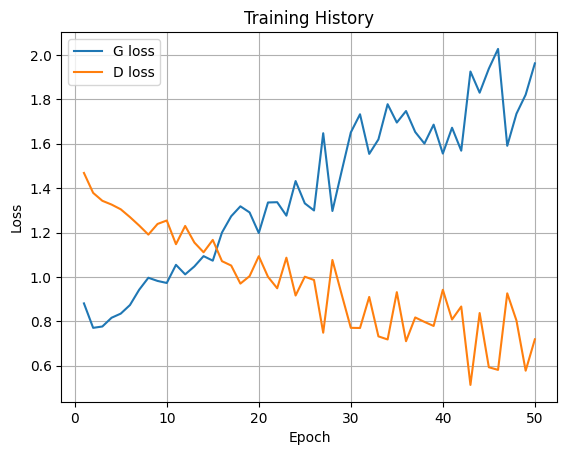

In [ ]:
plot_history("specgan_final.pkl")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_generated_data(generator, classifier, n_samples=200, z_dim=100, n_classes=10, le=None, device='cpu'):
    generator.eval()
    classifier.eval()

    z = torch.randn(n_samples, z_dim).to(device)
    labels = torch.randint(0, n_classes, (n_samples,), dtype=torch.long).to(device)

    with torch.no_grad():
        fake_imgs = generator(z, labels)

        preds = classifier(fake_imgs.to(device))
        pred_labels = preds.argmax(dim=1).cpu().numpy()

    true_labels = labels.cpu().numpy()

    print("Classification Report:")
    print(classification_report(true_labels, pred_labels, target_names=le.classes_ if le else None))

    print("Confusion Matrix:")
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_ if le else None)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.tight_layout()
    plt.show()

    return true_labels, pred_labels

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def train_simple_classifier(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, le):
    X_train_flat = X_train_tensor.numpy().reshape(len(X_train_tensor), -1)
    X_test_flat = X_test_tensor.numpy().reshape(len(X_test_tensor), -1)
    y_train = y_train_tensor.numpy()
    y_test = y_test_tensor.numpy()

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_flat, y_train)

    y_pred = clf.predict(X_test_flat)

    print("Classification Report (Logistic Regression):")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix (Test Set)")
    plt.tight_layout()
    plt.show()

    return clf

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

  chattering       0.99      0.96      0.97        94
     screech       0.96      0.99      0.98       106

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



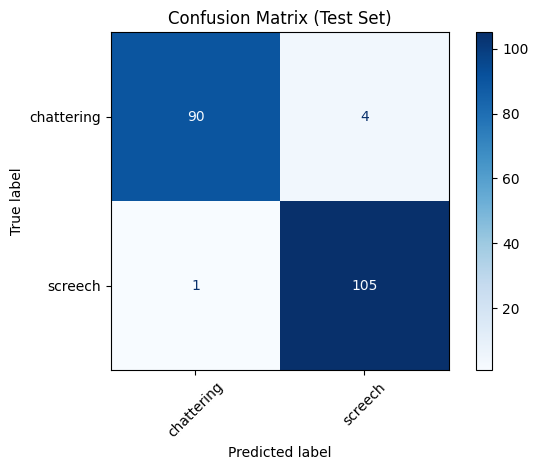

In [ ]:
clf = train_simple_classifier(X_split[0], y_split[0], X_split[2], y_split[2], le)

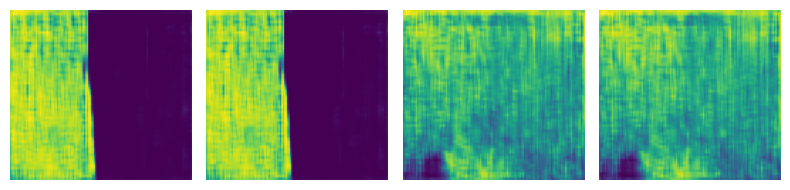

In [ ]:
def save_generated_samples(generator, epoch, n_samples=4):
    generator.eval()
    z = torch.randn(n_samples, z_dim).to(device)
    labels = torch.randint(0, n_classes, (n_samples,)).to(device)
    gen_imgs = generator(z, labels).detach().cpu().numpy()

    fig, axs = plt.subplots(1, n_samples, figsize=(n_samples * 2, 2))
    for i in range(n_samples):
        axs[i].imshow(gen_imgs[i].transpose(1, 2, 0), aspect='auto')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()
    generator.train()

save_generated_samples(G, epoch=n_epochs)

In [ ]:
def convert_mel_to_audio(mel_tensor, sr=22050, n_fft=1024, hop_length=256, n_mels=64, output_dir="generated_audio"):
    os.makedirs(output_dir, exist_ok=True)
    for i, mel_img in enumerate(mel_tensor):
        mel = mel_img[0]
        mel = (mel + 1.0) / 2.0
        mel_db = mel * 80.0 - 80.0
        mel_power = librosa.db_to_power(mel_db)
        mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
        inv_mel_basis = np.linalg.pinv(mel_basis)
        linear_spec = np.dot(inv_mel_basis, mel_power)
        audio = librosa.griffinlim(linear_spec, n_iter=60, hop_length=hop_length, win_length=n_fft)
        output_path = os.path.join(output_dir, f"gen_{i}.wav")
        sf.write(output_path, audio, sr)

def visualize_generated_specs(generator, n_samples=4):
    generator.eval()
    z = torch.randn(n_samples, z_dim).to(device)
    labels = torch.randint(0, n_classes, (n_samples,)).to(device)
    with torch.no_grad():
        gen_imgs = generator(z, labels).cpu().numpy()
    fig, axs = plt.subplots(1, n_samples, figsize=(n_samples * 3, 3))
    for i in range(n_samples):
        img = gen_imgs[i][0]
        axs[i].imshow(img, aspect="auto", origin="lower", cmap="magma")
        axs[i].axis("off")
        axs[i].set_title(f"Label {labels[i].item()}")
    plt.tight_layout()
    plt.show()
    generator.train()

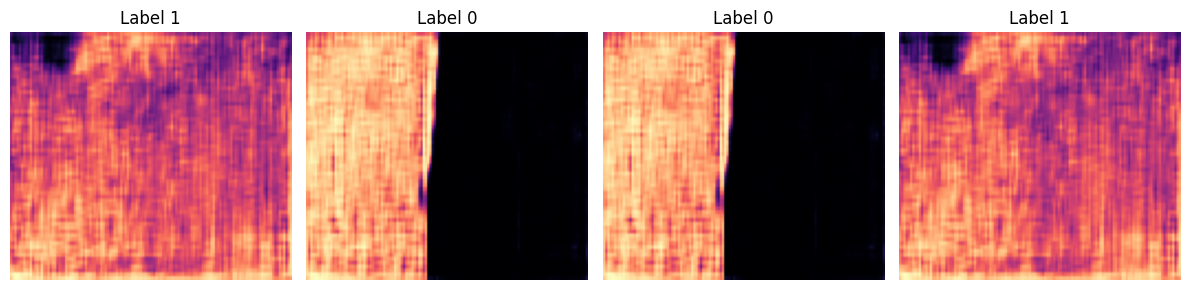

In [ ]:
visualize_generated_specs(G, n_samples=4)

In [ ]:
from google.colab import files

G.eval()
z = torch.randn(4, z_dim).to(device)
labels = torch.randint(0, n_classes, (4,)).to(device)
gen_imgs = G(z, labels).detach().cpu().numpy()
convert_mel_to_audio(gen_imgs, sr=22050)

ipd.Audio("generated_audio/gen_0.wav")

In [ ]:
files.download("generated_audio/gen_0.wav")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>